In [ ]:
import pandas as pd
covid19World = pd.read_csv('https://covid.ourworldindata.org/data/owid-covid-data.csv')

In [2]:
covid19SG = covid19World.loc[covid19World['location']=='Singapore']
covid19SG = covid19SG.loc[covid19SG['total_cases']>0]
covid19DailyCase = covid19SG.loc[:,['date','total_cases','new_cases']]
covid19DailyCase = covid19DailyCase.reset_index(drop=True)
covid19DailyCase['new_cases']= covid19DailyCase['new_cases'].astype(int)
covid19DailyCase['total_cases']= covid19DailyCase['total_cases'].astype(int)
covid19DailyCase.describe()

,total_cases,new_cases
count,121.000000,121.000000
mean,6035.710744,251.454545
std,9436.348519,345.408068
min,3.000000,0.000000
25%,89.000000,3.000000
50%,509.000000,32.000000
75%,10141.000000,528.000000
max,30426.000000,1426.000000


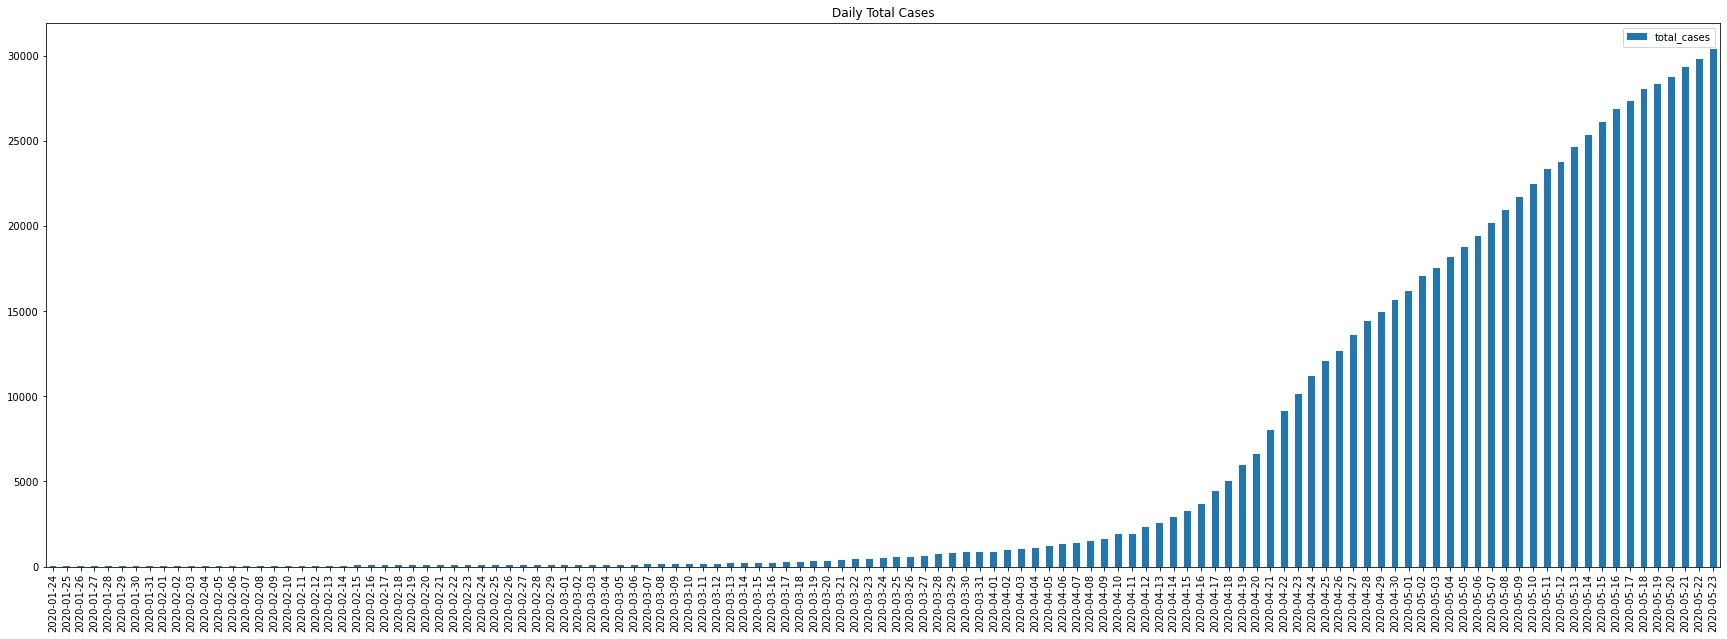

In [3]:
ax = covid19DailyCase[['total_cases','date']].plot(kind='bar', figsize=(30,10), title="Daily Total Cases")
ax.set_xticklabels(covid19DailyCase['date']);

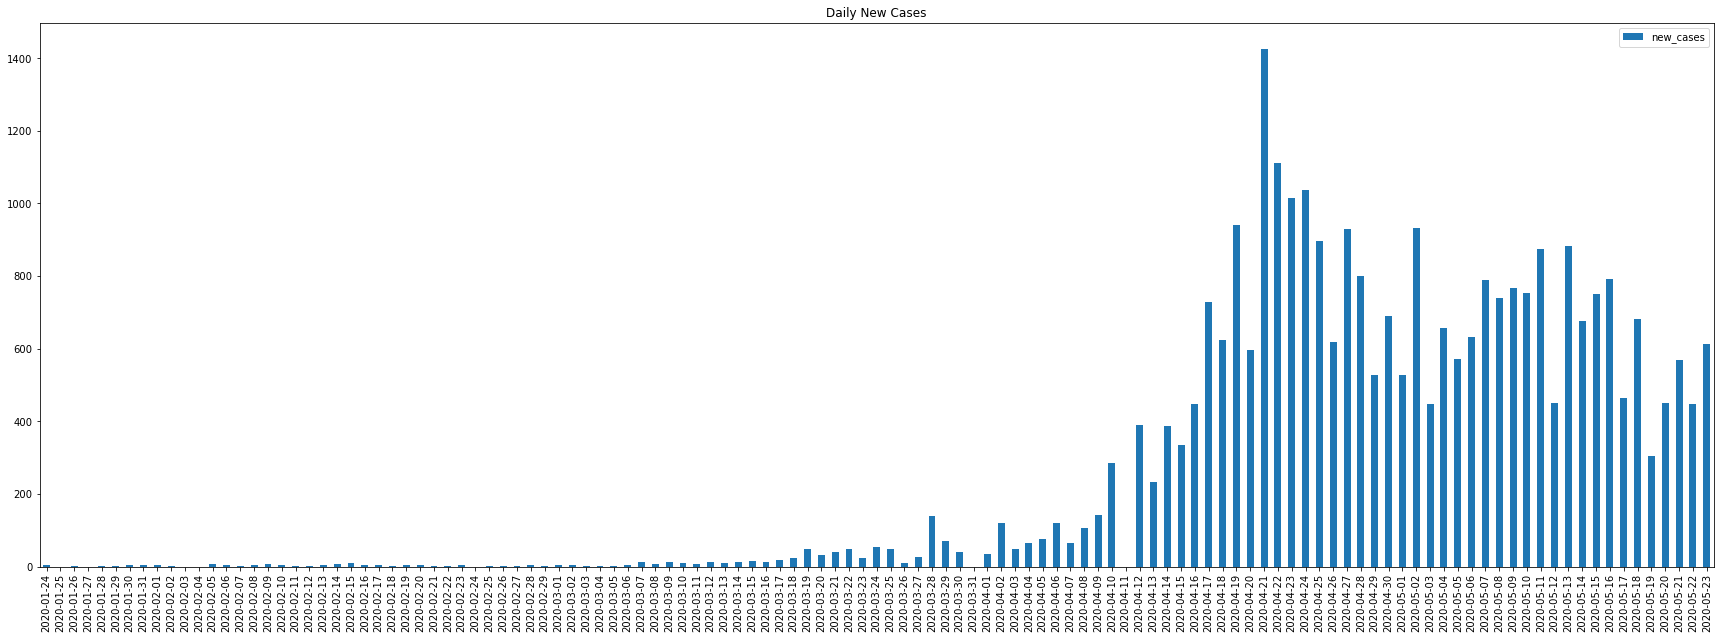

In [4]:
ax = covid19DailyCase[['new_cases','date']].plot(kind='bar', figsize=(30,10), title="Daily New Cases")
ax.set_xticklabels(covid19DailyCase['date']);

In [5]:
## We applied Population Growth Model
#  yi=β1/(1+exp(β2+β3xi))+ϵi
#  https://online.stat.psu.edu/stat501/lesson/15/15.8

In [6]:
# Solving initial condition

# From the graph, we noticed the peak increase at 22/April and 26/April
# Assume the peak growth is at 24/April (halfway point) 
# We use this data to calculate intial beta1 value
beta1 = 2 * covid19DailyCase[covid19DailyCase['date'] == '2020-04-22'].total_cases.iloc[0]

# We use 24/Jan and 06/Apr value as two starting point to calculate inital beta2 and beta3 values
import numpy as np

#np.array([[1, covid19SG[covid19SG['date'] == '2020-01-24'].index], [1, covid19SG[covid19SG['date'] == '2020-04-06'].index]])
#np.log(beta1.values/(covid19SG[covid19SG['date'] == '2020-01-24'].total_cases - 1))
#np.log(beta1.values/(covid19SG[covid19SG['date'] == '2020-04-06'].total_cases - 1))
A = np.array([[1, 0], [1, 73]])
y = np.array([9.118773,2.635666])
beta2, beta3 = np.linalg.solve(A,y)
beta1, beta2, beta3


(18250, 9.118773, -0.08880968493150683)

In [7]:
initialY = beta1 / (1 + np.exp(beta2 + beta3 * covid19SG.index.values))
# To continue using Non-linear Least Squared Method
# https://en.wikipedia.org/wiki/Non-linear_least_squares

In [8]:
# We use python library for curve_fit
from scipy.optimize import curve_fit

def populationGrowthModel(x, b1, b2, b3):
    return b1 / (1 + np.exp(b2 + b3 * x))

# fit model on original data
xGrowth = covid19DailyCase.index.values
yGrowth = covid19DailyCase['total_cases'].values

poptGrowth, pcovGrowth = curve_fit(populationGrowthModel, xGrowth, yGrowth, p0=[beta1, beta2, beta3])
poptGrowth, pcovGrowth

(array([ 3.15553948e+04,  1.13094268e+01, -1.15489584e-01]),
 array([[ 1.52679292e+05, -6.55910337e+01,  8.03182458e-01],
        [-6.55910337e+01,  4.93061276e-02, -5.59653389e-04],
        [ 8.03182458e-01, -5.59653389e-04,  6.42507675e-06]]))

In [9]:
# fit model on 3 day average 
yGrowthAvg3 = covid19DailyCase['total_cases'].rolling(window=3).mean()

poptGrowthAvg, pcovGrowthAvg = curve_fit(populationGrowthModel, xGrowth, np.nan_to_num(yGrowthAvg3), p0=[beta1, beta2, beta3])
poptGrowthAvg, pcovGrowthAvg

(array([ 3.11623278e+04,  1.15366061e+01, -1.16948529e-01]),
 array([[ 1.51363951e+05, -6.61611367e+01,  8.03038382e-01],
        [-6.61611367e+01,  4.99529650e-02, -5.63230752e-04],
        [ 8.03038382e-01, -5.63230752e-04,  6.42043375e-06]]))

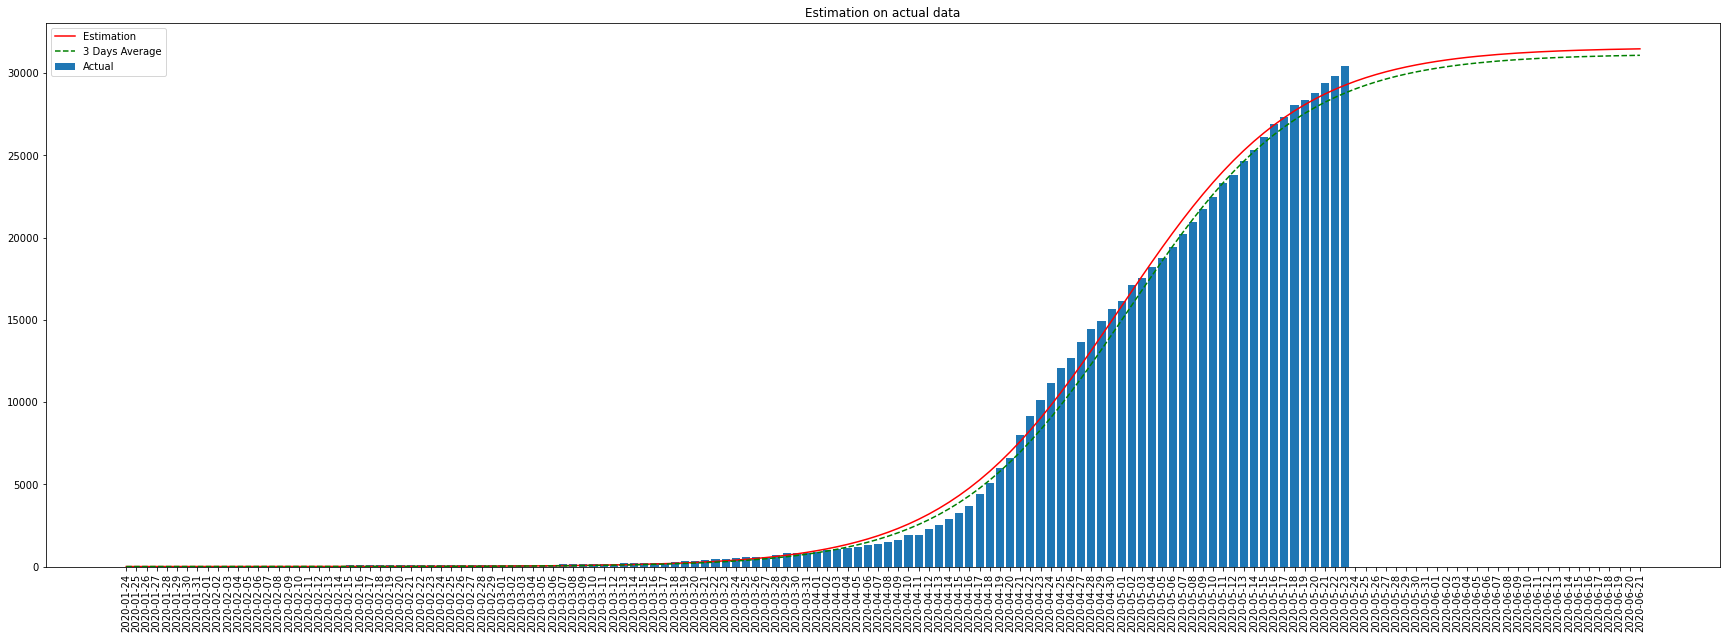

array([ 3.15553948e+04,  1.13094268e+01, -1.15489584e-01])

In [10]:
import matplotlib.pyplot as plt
estimationRage = range(0,150)

plt.figure(figsize=(30,10))
plt.plot(estimationRage, populationGrowthModel(estimationRage, *poptGrowth), 'r', label='Estimation')
plt.plot(estimationRage, populationGrowthModel(estimationRage, *poptGrowthAvg), '--g', label='3 Days Average')
plt.bar(estimationRage, np.pad(covid19DailyCase['total_cases'].values, 
        (0, len(estimationRage)-covid19DailyCase['total_cases'].size), 'constant'),label='Actual')
plt.legend();
plt.title('Estimation on actual data')
plt.xticks(estimationRage,np.array('2020-01-24', dtype=np.datetime64) + estimationRage, rotation=90)
plt.show()
poptGrowth

In [11]:
## Verify its change rate
# Change rate is a symmetric function, which is different from most of the observations on other countries
#ax = plt.figure(figsize=(30,10))
#ax = plt.plot(np.diff(populationGrowthModel(estimationRage, *poptGrowth)))

In [12]:
## We enhance the estimation using Exponentially modified Gaussian distribution
# https://en.wikipedia.org/wiki/Exponentially_modified_Gaussian_distribution
from scipy.stats import exponnorm
from scipy.optimize import curve_fit

def populationGrowthRateModel(x, loc, scale, K, d):
    return d * exponnorm.pdf(x, K, loc, scale)

xGrowthRate = covid19DailyCase.index.values
yGrowthRate = covid19DailyCase['new_cases'].values

poptRate, pcovRate = curve_fit(populationGrowthRateModel, xGrowthRate, yGrowthRate)

yGrowthRateAvg3 = covid19DailyCase['new_cases'].rolling(window=3).mean()
poptGrowthRateAvg, pcovGrowthRateAvg = curve_fit(populationGrowthRateModel, 
                                                 xGrowthRate, np.nan_to_num(yGrowthRateAvg3))
poptGrowthRateAvg, pcovGrowthRateAvg
print(poptRate)
print(poptGrowthRateAvg)


[8.22487207e+01 3.73871108e+00 1.38266645e+01 5.52377624e+04]
[8.31911740e+01 3.82364798e+00 1.34868571e+01 5.50667773e+04]


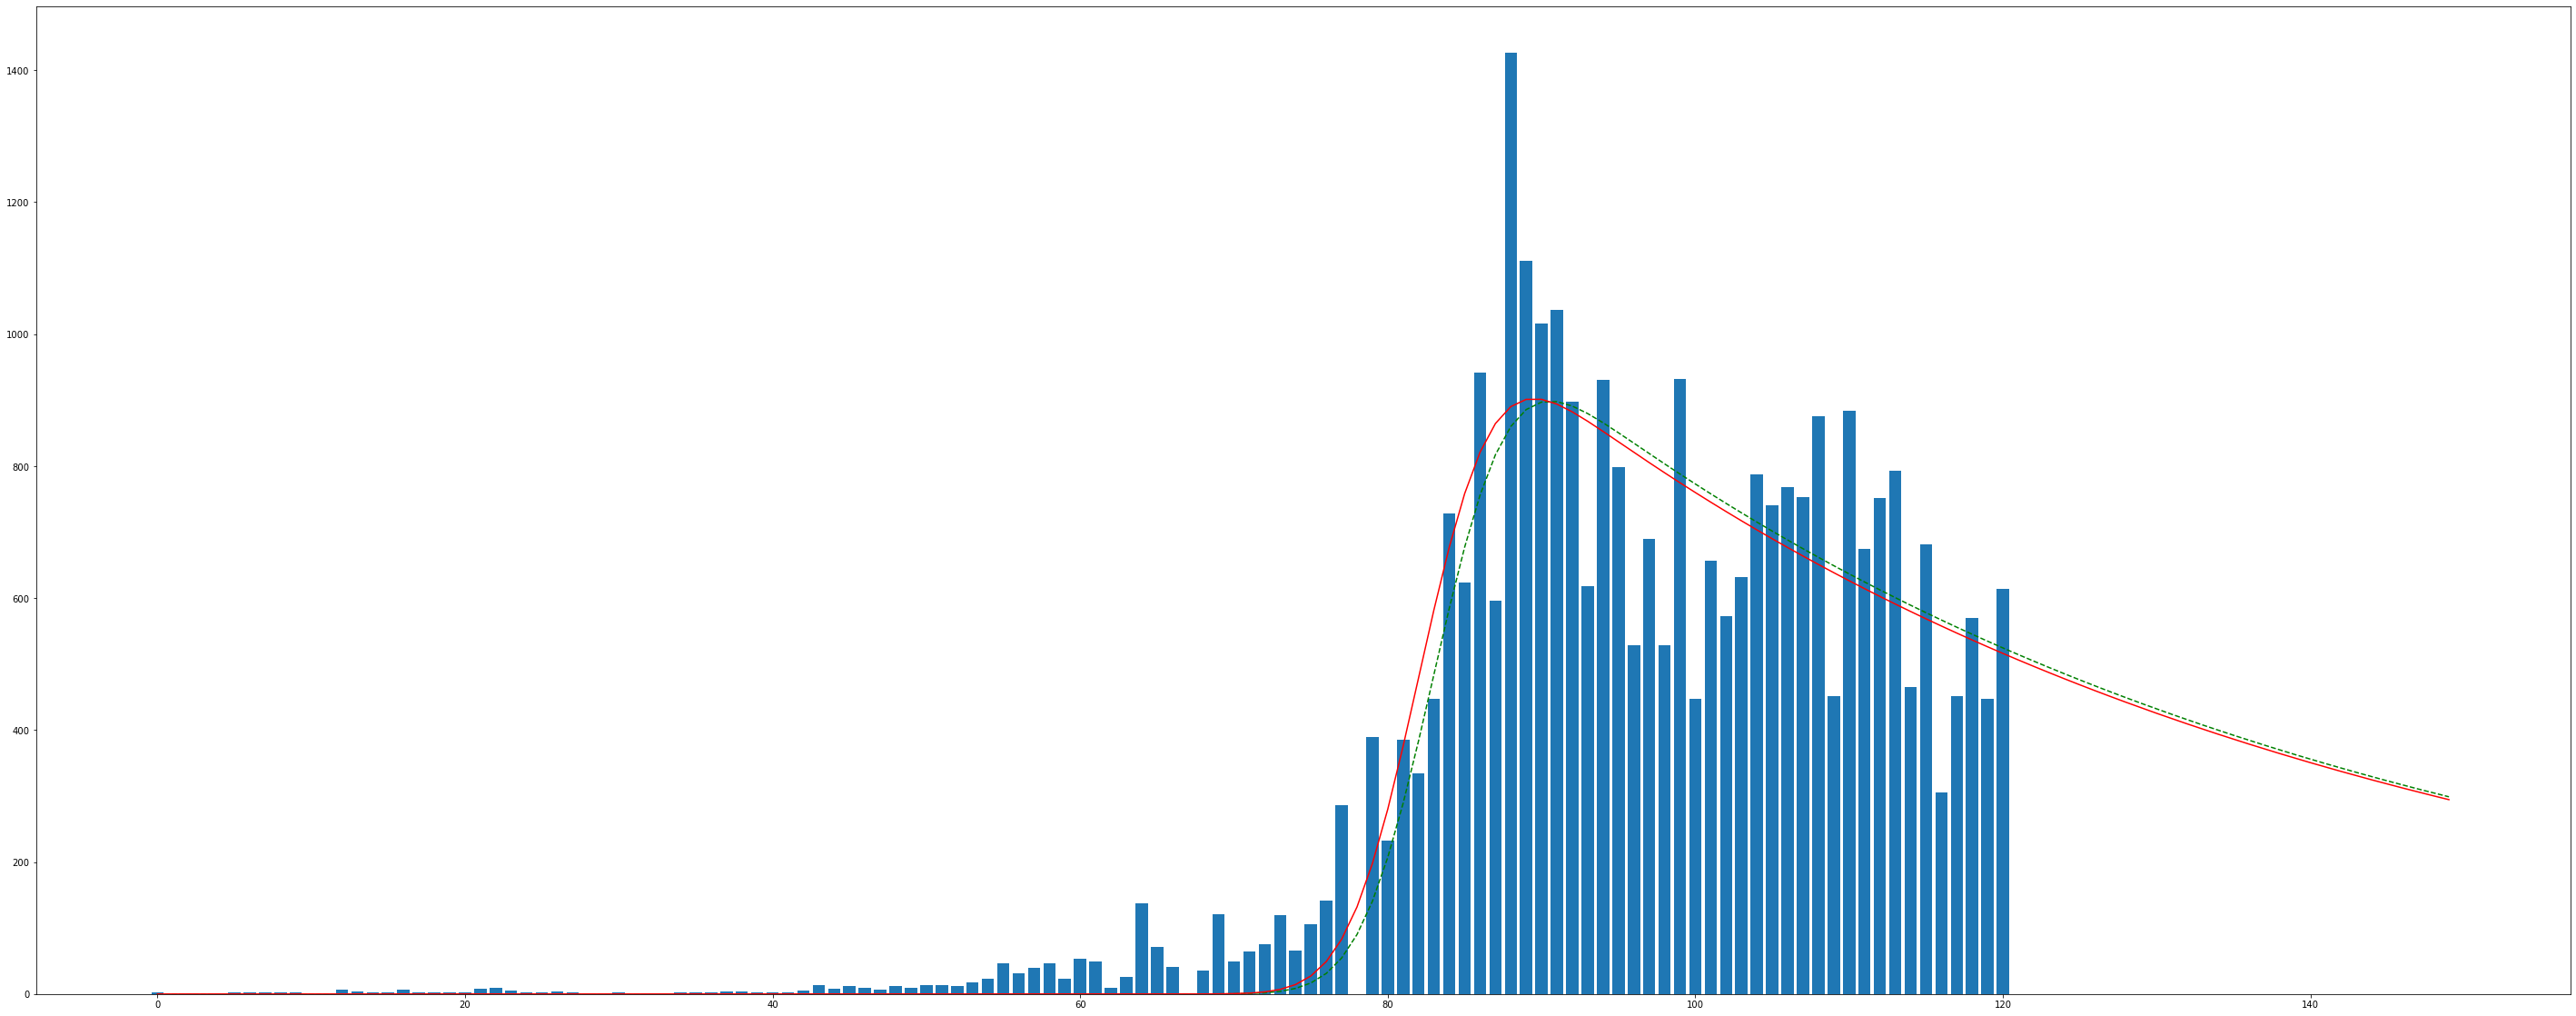

array([1.56024451e-104, 5.49073120e-102, 1.79440946e-099, ...,
       5.52377624e+004, 5.52377624e+004, 5.52377624e+004])

In [13]:
estimationRage = range(0,150)
plt.figure(figsize=(50,20))

plt.plot(estimationRage, populationGrowthRateModel(estimationRage, *poptGrowthRateAvg), '--g', label='3 Days Average')
plt.plot(estimationRage, populationGrowthRateModel(estimationRage, *poptRate), 'r-')
plt.bar(estimationRage, np.pad(covid19SG['new_cases'].values, (0, len(estimationRage)-covid19SG['total_cases'].size), 'constant'))
plt.show()
populationGrowthRateModel(range(0,3000), *poptRate).cumsum()

In [14]:
## 17 May 2020
# There are few phases of Covid 19 situation in Singapore
# Foreign Import -> Local Transmission -> Worker Dorm Outbreak
# 1. Foreign Import cases are cleared to zero after close border policy -> minor impact on total numbers
# 2. Local Transmission cases have been reduced after Circuit Breaker measures -> medium impact on total numbers
# 3. Worker Dorm cases are huge and growing fast -> huge impact on total numbers
# (Experiment) We seperate 2 and 3 into two different models and use the aggregation to simulate the case


In [15]:
def popGrowthRateTwoModel(x, loc1, scale1, K1, d1, loc2, scale2, K2, d2):
    return d1 * exponnorm.pdf(x, K1, loc1, scale1) + d2 * exponnorm.pdf(x, K2, loc2, scale2)

xGrowthRate = covid19DailyCase.index.values
yGrowthRate = covid19DailyCase['new_cases'].values

# We estimate the third wave - Woker Dorm based on the estimated values of original estimation
poptGrowthRateTwoMod, pcovGrowthRateTwoMod = curve_fit(popGrowthRateTwoModel, xGrowthRate, yGrowthRate,
                                                       np.concatenate((poptRate,
                                                                       np.array([110, 4.0, 1.5, 8e+04]))), 
                                                       maxfev=3600)


yGrowthRateAvg3 = covid19DailyCase['new_cases'].rolling(window=3).mean()
poptGrowthRateTwoModAvg, pcovGrowthRateTwoModAvg = curve_fit(popGrowthRateTwoModel, xGrowthRate, np.nan_to_num(yGrowthRateAvg3),
                                                             np.concatenate((poptRate,
                                                                             np.array([110, 4.0, 1.5, 8e+04]))),
                                                             maxfev=12000)

print(poptGrowthRateTwoMod)
print(poptGrowthRateTwoModAvg)

[8.89664007e+01 5.62832278e+00 2.99232881e-02 1.41620250e+04
 1.01060861e+02 5.59325102e+00 2.84711820e+00 2.14783789e+04]
[9.00741891e+01 5.81788603e+00 3.01251969e-02 1.45112538e+04
 1.02580275e+02 5.51467937e+00 2.51446352e+00 1.97700681e+04]


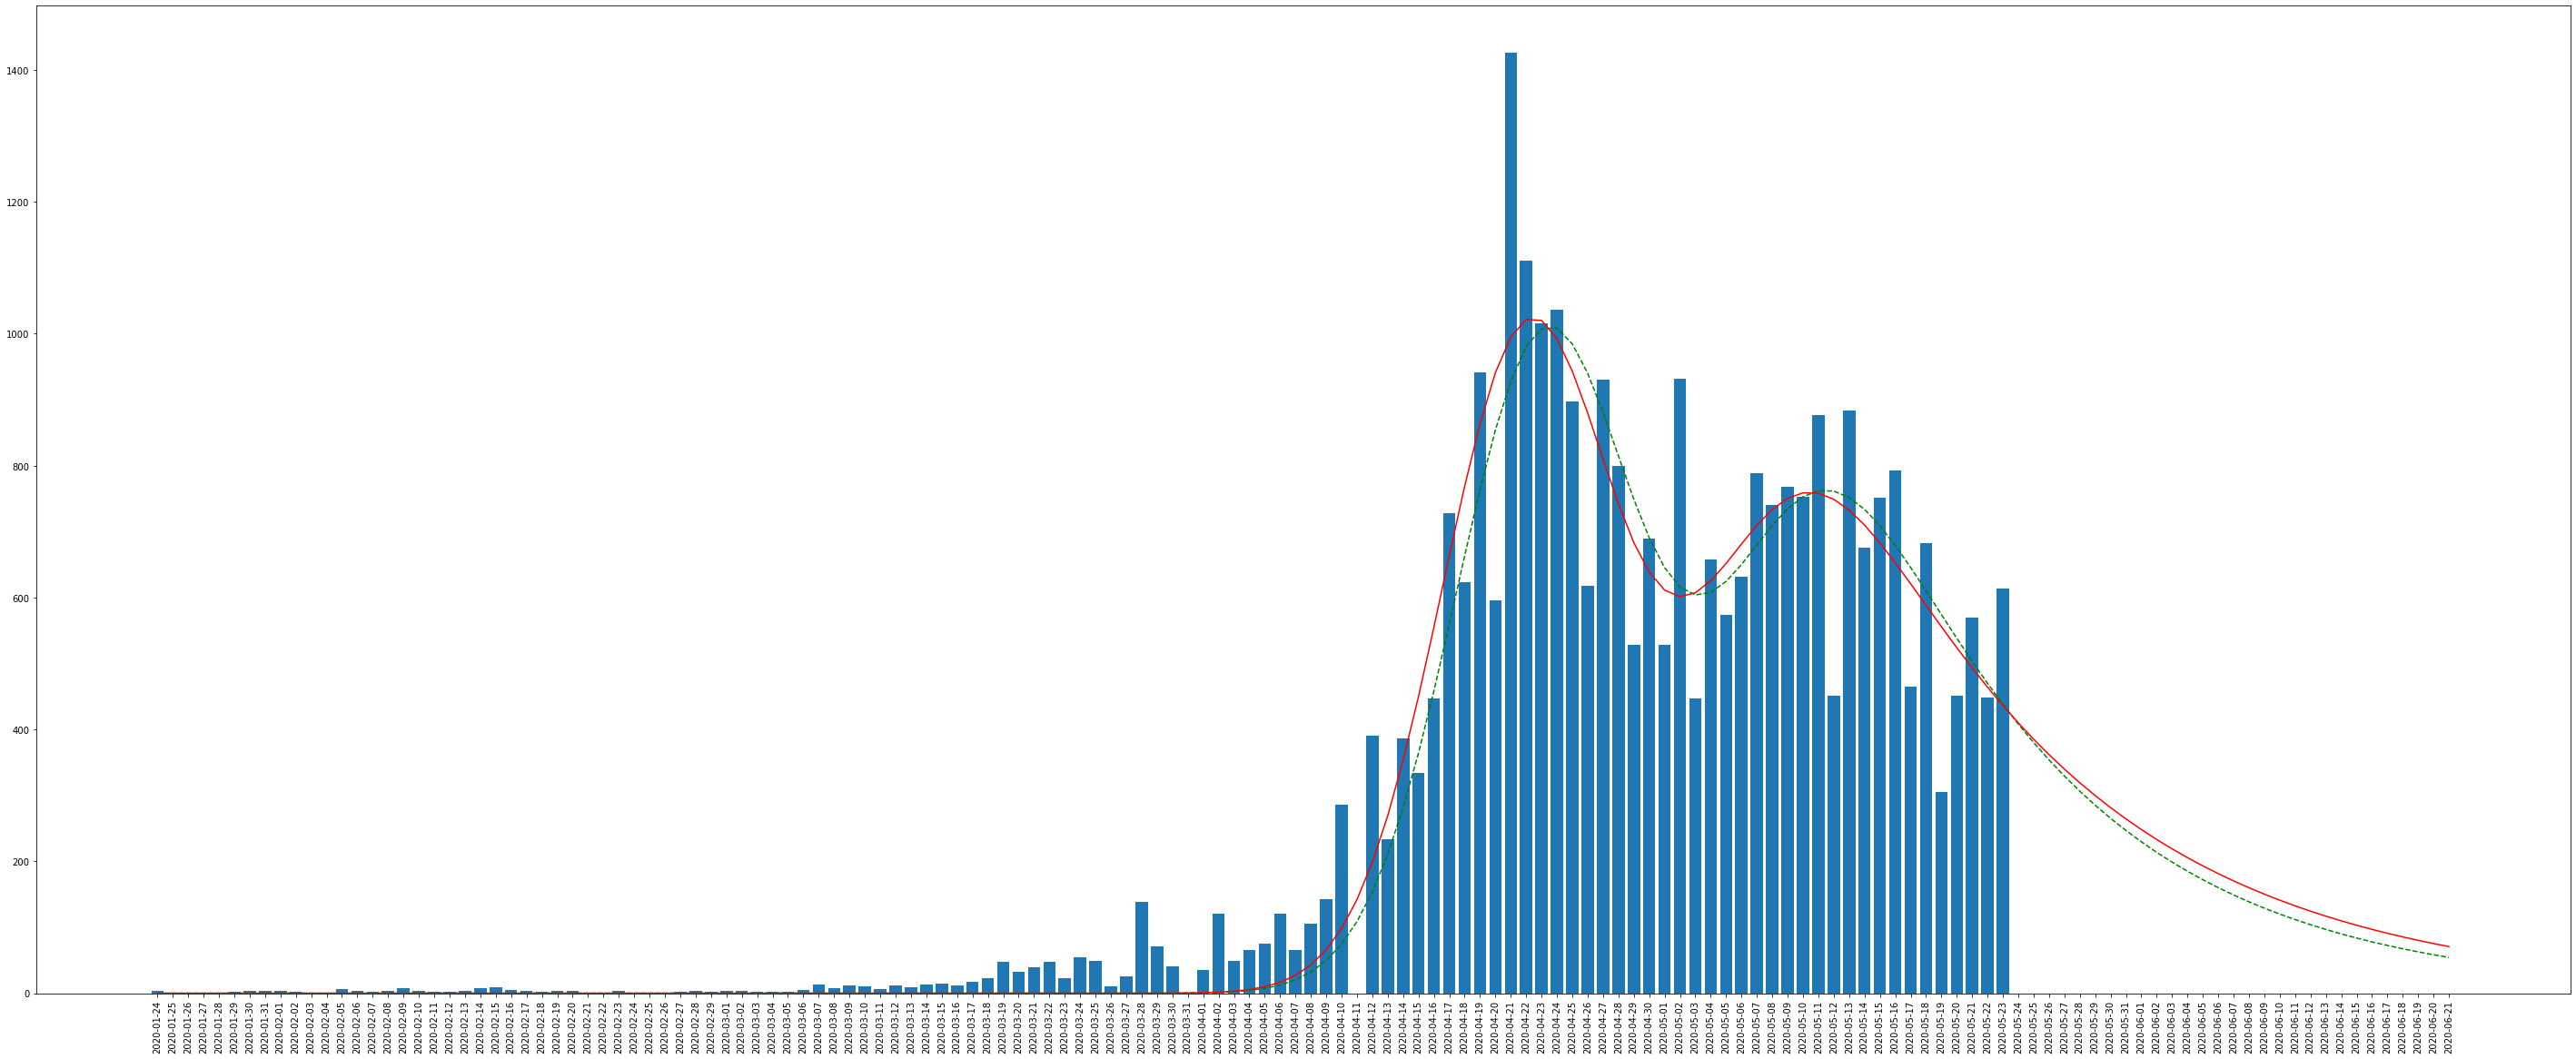

array([3.74280364e-70, 9.78029817e-69, 2.38747577e-67, ...,
       3.56403201e+04, 3.56403201e+04, 3.56403201e+04])

In [26]:
estimationRage = range(0,150)
plt.figure(figsize=(50,20))

plt.plot(estimationRage, popGrowthRateTwoModel(estimationRage, *poptGrowthRateTwoModAvg), '--g', label='3 Days Average')
plt.plot(estimationRage, popGrowthRateTwoModel(estimationRage, *poptGrowthRateTwoMod), 'r-')
plt.bar(estimationRage, np.pad(covid19SG['new_cases'].values, (0, len(estimationRage)-covid19SG['total_cases'].size), 'constant'))
plt.xticks(estimationRage,np.array('2020-01-24', dtype=np.datetime64) + estimationRage, rotation=90)
plt.show()
popGrowthRateTwoModel(range(0,3000), *poptGrowthRateTwoMod).cumsum()

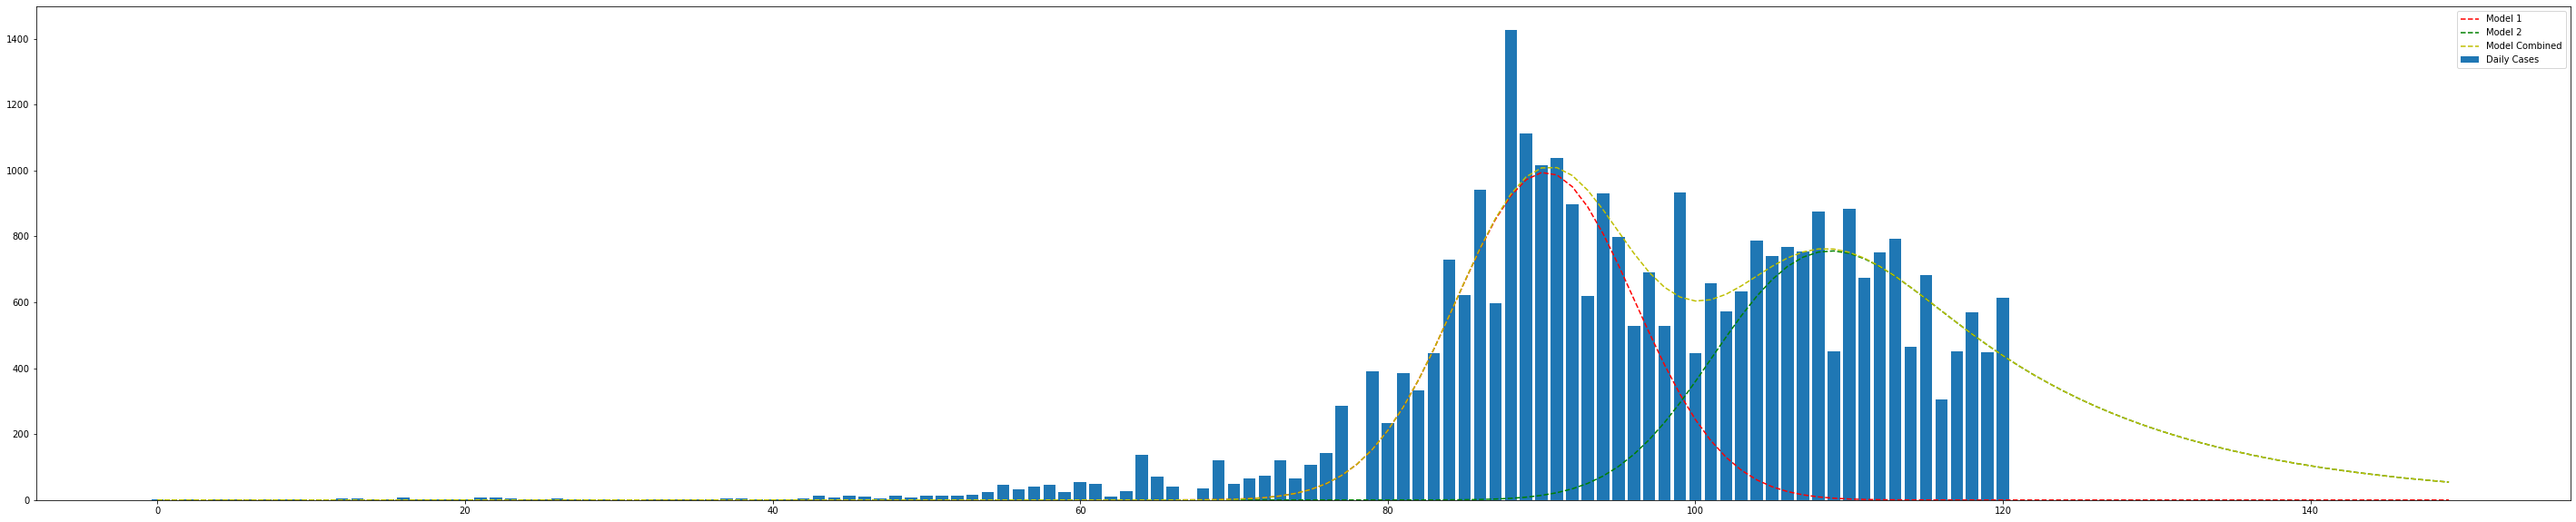

In [28]:
poptGrowthRateTwoMod[0]

def popGrowthRateModel(x, loc1, scale1, K1, d1):
    return d1 * exponnorm.pdf(x, K1, loc1, scale1)

estimationRage = range(0,150)
plt.figure(figsize=(50,10))

plt.plot(estimationRage, popGrowthRateModel(estimationRage, *poptGrowthRateTwoModAvg[0:4]), 
         '--r', label='Model 1')
plt.plot(estimationRage, popGrowthRateModel(estimationRage, *poptGrowthRateTwoModAvg[4:]), 
         '--g', label='Model 2')
plt.plot(estimationRage, popGrowthRateTwoModel(estimationRage, *poptGrowthRateTwoModAvg), 
         '--y', label='Model Combined')
plt.bar(estimationRage, np.pad(covid19SG['new_cases'].values, 
                               (0, len(estimationRage)-covid19SG['total_cases'].size), 'constant'),
       label='Daily Cases')
plt.legend();


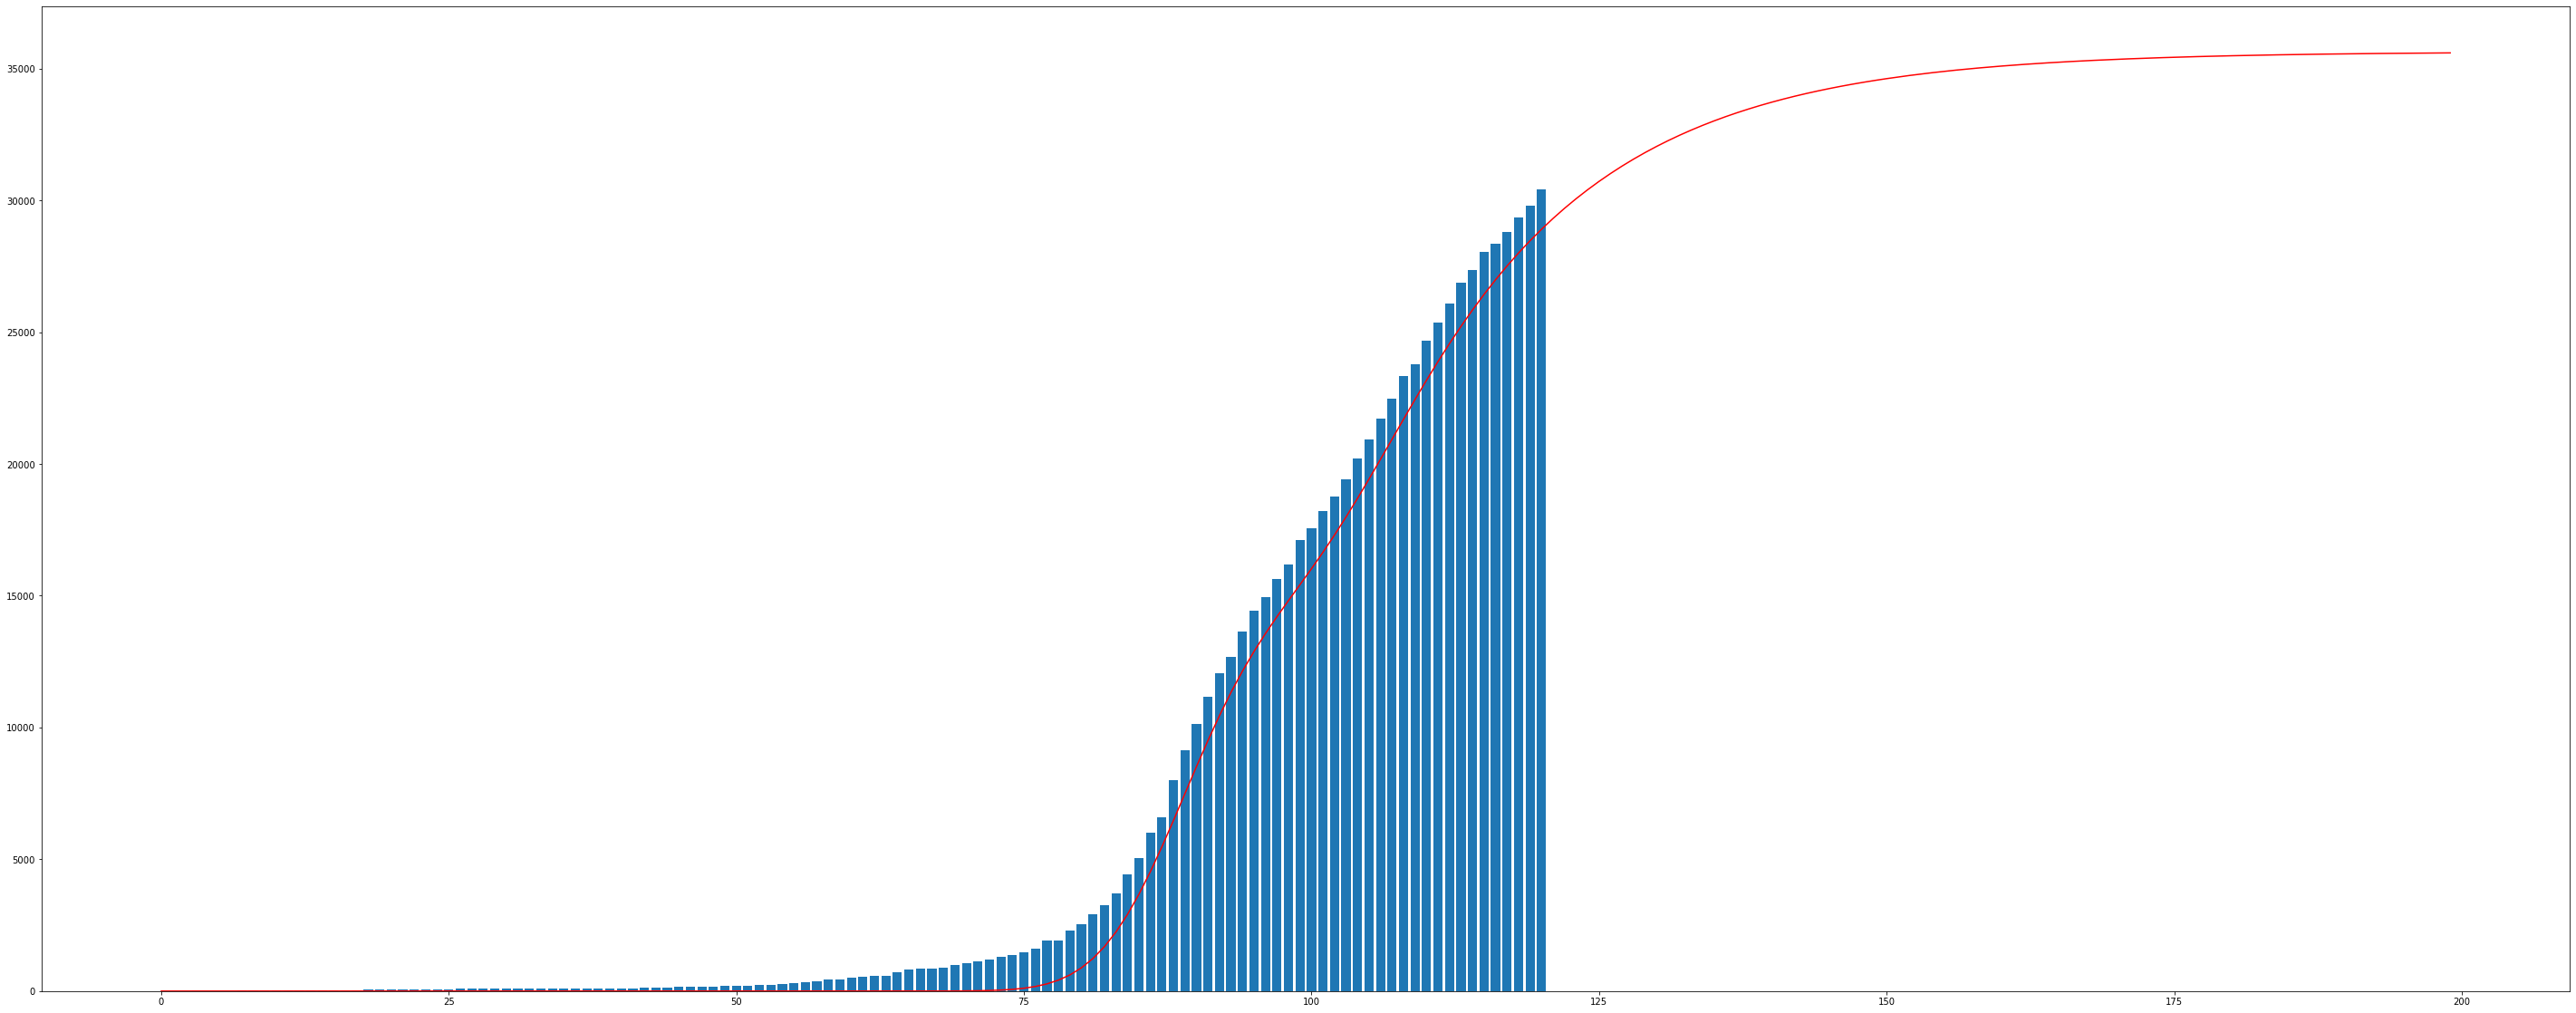

In [29]:
estimationRage = range(0,200)
plt.figure(figsize=(50,20))
plt.plot(estimationRage, popGrowthRateTwoModel(estimationRage, *poptGrowthRateTwoMod).cumsum(), 'r-')
plt.bar(estimationRage, np.pad(covid19SG['total_cases'].values, 
                               (0, len(estimationRage)-covid19SG['total_cases'].size), 'constant'))
plt.show()

In [18]:
## (Experiment) Go back to original population growth model definetion

def populationGrowthRateModel(x, rate, capacity, N):
    return rate * capacity /(capacity - N) * N

xGrowthRate = covid19DailyCase.index.values
yGrowthRate = covid19DailyCase['new_cases'].values

poptRate, pcovRate = curve_fit(populationGrowthRateModel, xGrowthRate, yGrowthRate)
poptRate, pcovRate

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in double_scalars
  after removing the cwd from sys.path.
/opt/conda/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


(array([1., 1., 1.]),
 array([[inf, inf, inf],
        [inf, inf, inf],
        [inf, inf, inf]]))